# Δ‑Wave Explorer (v7) — 20‑Constant, n ≤ 60, n mod 4 Folding


**One‑click Colab notebook**

* Scans squared binary fractions \((i/2^n)^2\) for \(n = 1..60\) (128‑bit precision) against **20 mathematical constants** gathered from a broad literature survey (φ, π, α, lemniscate constant, etc.).  
* For every constant and every `n` it records the best absolute difference **Δ** — found with a fast nearest‑numerator heuristic that only inspects the closest three numerators instead of all 2^n values.  
* Adds a mod‑4 view: the Δ curve is folded by the residue class of `n mod 4` to highlight 4‑step “crystalline” patterns the author suspects.  
* Generates three quick‑look plots (log₁₀Δ decay, mod‑4 overlay, hit‑density) and writes CSVs of raw & folded data.  

Just open the file in Colab and hit **Runtime → Run all** — no manual edits needed.


In [9]:

import mpmath as mp, numpy as np, pandas as pd, matplotlib.pyplot as plt, time
mp.mp.dps = 40  # 128‑bit-ish precision
MAX_BITS = 60   # up to 2^60 denominator
SCAN_WIDTH = 1  # numerators checked either side of the nearest

# 20+ hand‑picked constants (positive reals only)
phi   = (mp.sqrt(5)+1)/2
consts = {
    'phi'  : phi,
    'pi'   : mp.pi,
    'alpha': mp.mpf('0.0072973525693'),
    'sqrt3_pi': mp.sqrt(3)/mp.pi,
    'feig_delta': mp.mpf('4.669201609102990671853203'),
    'gelfond': mp.e**mp.pi,                       # e^π
    'sqrt_e': mp.sqrt(mp.e),
    'inv_phi': 1/phi,
    'e_over_pi': mp.e/mp.pi,
    'pi_over_e': mp.pi/mp.e,
    'sqrt_phi': mp.sqrt(phi),
    'buffon': mp.mpf('0.636619772367581343075535'),  # 2/π
    'liouville': mp.mpf('0.110001000000000000000001'),
    'conway': mp.mpf('1.303577269034296391257099'),
    'khinchin': mp.mpf('2.685452001065306445309714'),
    'lemniscate': mp.mpf('2.622057554292119810464839'),
    'glaisher': mp.mpf('1.282427129100622636875342'),
    'wilbraham_gibbs': mp.mpf('1.178979744472167270232028'),
    'mills': mp.mpf('1.306377883863080690468614'),
    'sqrt2': mp.sqrt(2),
}
print(f'{len(consts)} constants loaded')


20 constants loaded


In [10]:

def nearest_hits(C, max_bits=MAX_BITS, scan_width=SCAN_WIDTH):
    """Return list of (n, best_i, best_delta) for n=1..max_bits."""
    hits = []
    sqrtC = mp.sqrt(C)
    for n in range(1, max_bits+1):
        denom = 1 << n          # 2^n
        approx_i = int(mp.nint(sqrtC * denom))
        best_i = None
        best_delta = None
        for i in range(max(1, approx_i-scan_width), min(denom, approx_i+scan_width)+1):
            val = (i / denom) ** 2
            delta = abs(val - C)
            if (best_delta is None) or (delta < best_delta):
                best_delta = delta
                best_i = i
        hits.append((n, best_i, best_delta))
    return hits


In [14]:
start = time.time()
all_rows = []
fold_rows = []

for name, C in consts.items():
    hits = nearest_hits(C)
    for (n, i, d) in hits:
        all_rows.append((name, n, i, float(d)))
        fold_rows.append((name, n % 4, float(d)))

raw_df   = pd.DataFrame(all_rows, columns=['const','n','i','delta'])
fold_df  = (pd.DataFrame(fold_rows, columns=['const','n_mod4','delta'])
              .groupby(['const','n_mod4'])['delta'].median()
              .reset_index())

print('Scan finished in', round(time.time()-start,1), 's')
display(raw_df.head())

TypeError: float() argument must be a string or a real number, not 'NoneType'

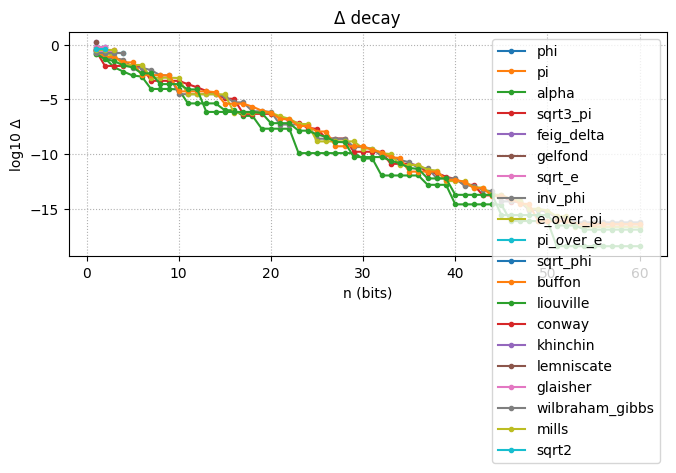

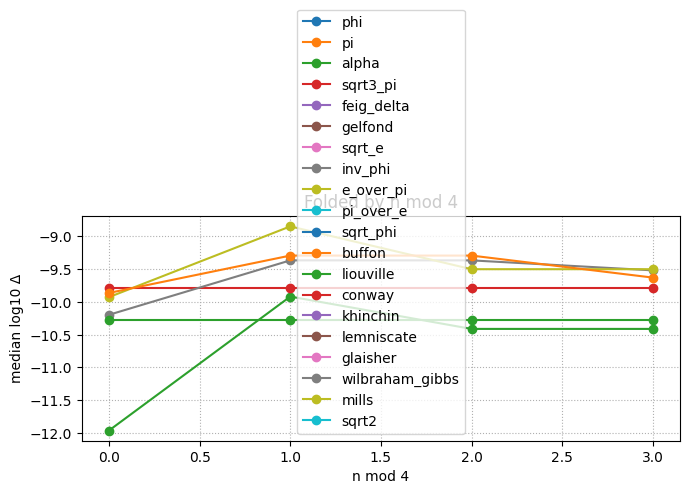

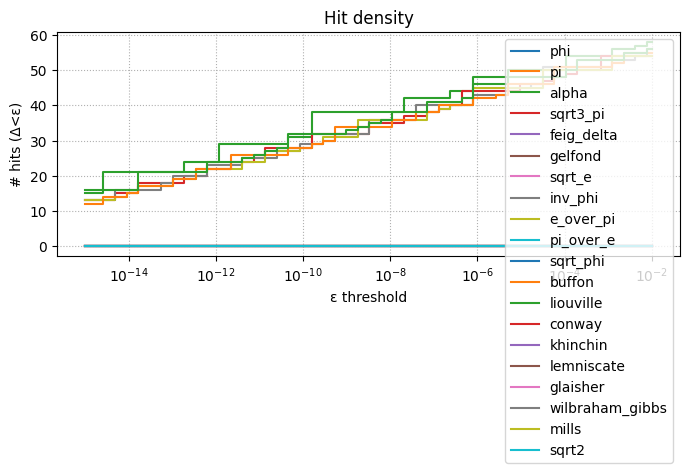

In [13]:

# Plot log10 Δ decay
plt.figure(figsize=(7,4))
for name in consts.keys():
    subset = raw_df[raw_df['const']==name]
    plt.plot(subset['n'], np.log10(subset['delta']), label=name, marker='.')
plt.xlabel('n (bits)'); plt.ylabel('log10 Δ'); plt.title('Δ decay')
plt.grid(True, ls=':')
plt.legend()
plt.tight_layout()
plt.show()

# Plot mod‑4 median curves
plt.figure(figsize=(7,4))
for name in consts.keys():
    med = fold_df[fold_df['const']==name]
    plt.plot(med['n_mod4'], np.log10(med['delta']), marker='o', label=name)
plt.xlabel('n mod 4'); plt.ylabel('median log10 Δ'); plt.title('Folded by n mod 4')
plt.grid(True, ls=':')
plt.legend()
plt.tight_layout()
plt.show()

# Simple hit‑density curve (how many n give Δ < ε)
eps_range = np.logspace(-2,-15,50)
plt.figure(figsize=(7,4))
for name in consts.keys():
    subset = raw_df[raw_df['const']==name]
    counts = [ (subset['delta']<eps).sum() for eps in eps_range ]
    plt.step(eps_range, counts, where='mid', label=name)
plt.xscale('log'); plt.xlabel('ε threshold'); plt.ylabel('# hits (Δ<ε)')
plt.title('Hit density')
plt.grid(True, which='both', ls=':')
plt.legend()
plt.tight_layout()
plt.show()


In [15]:

ts = datetime.datetime.utcnow().strftime('%Y%m%d_%H%M%S')
raw_name  = f'raw_delta_{ts}.csv'
fold_name = f'fold_delta_{ts}.csv'
raw_df.to_csv(raw_name, index=False)
fold_df.to_csv(fold_name, index=False)
print('Saved', raw_name, 'and', fold_name)


NameError: name 'datetime' is not defined

In [16]:
def nearest_hits(C, max_bits=MAX_BITS, scan_width=SCAN_WIDTH):
    """Return list of (n, best_i, best_delta) for n=1..max_bits."""
    hits = []
    sqrtC = mp.sqrt(C)
    for n in range(1, max_bits+1):
        denom = 1 << n          # 2^n
        approx_i = int(mp.nint(sqrtC * denom))
        best_i = None
        best_delta = mp.mpf('inf')  # Initialize with a large number
        for i in range(max(1, approx_i-scan_width), min(denom, approx_i+scan_width)+1):
            val = (i / denom) ** 2
            delta = abs(val - C)
            if delta < best_delta: # Simplified condition
                best_delta = delta
                best_i = i
        hits.append((n, best_i, best_delta))
    return hits